In [44]:
import tensorflow as tf
import tensorflow.contrib.keras as keras
from PIL import Image
from sklearn.model_selection import train_test_split as ttsplit
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from imutils import paths
import pandas as pd

In [14]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [15]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images('survivalDataSet'))

data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [16]:
len(labels)

72

In [17]:
len(data)

72

In [18]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(x_train0, x_test0, y_train0, y_test0) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [19]:
len(x_train0),len(y_train0),len(x_test0),len(y_test0)

(57, 57, 15, 15)

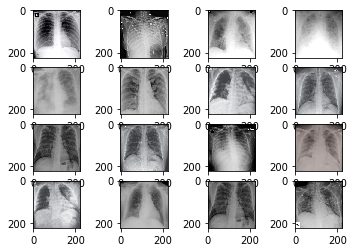

In [20]:
nImg = 4

for i in range(nImg*nImg):
    plt.subplot(nImg, nImg, i+1)
    plt.imshow(x_train0[i], cmap = 'Greys_r')
plt.show()

# set seeds
np.random.seed(9987)
tf.set_random_seed(9987)

In [21]:
# preprocessing data
#1 reshape images
x_train = np.reshape(x_train0, [x_train0.shape[0], x_train0.shape[1], x_train0.shape[2], 3])
x_test = np.reshape(x_test0, [x_test0.shape[0], x_test0.shape[1], x_test0.shape[2], 3])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#generate class labels
y_train = keras.utils.to_categorical(y_train0)
y_test = keras.utils.to_categorical(y_test0)


# 30% of training set will be used for validation, and we do a hard cut to avoid randomness
p = 0.3
x_train_1, x_val, y_train_1, y_val = ttsplit(x_train, y_train, test_size = p, random_state = 0) 

print('Training Set', x_train_1.shape, y_train_1.shape)
print('validation Set', x_val.shape, y_val.shape)

Training Set (39, 224, 224, 3) (39, 2, 2)
validation Set (18, 224, 224, 3) (18, 2, 2)


In [26]:
#implement a feedforward NN: 2 hidden layers each have 50 hidden unites with tanh activation,
# and one output layer with 10 units for the 10 classes
model = keras.models.Sequential()

# first Conv layer
model.add(keras.layers.Conv2D(
    16,
    (9,9),
    activation = 'relu',
    input_shape = (224, 224,3)
))
model.add(keras.layers.MaxPooling2D((2, 2)))

#second
model.add(keras.layers.Conv2D(
    32,
    (3,3),
    activation = 'relu'
))
model.add(keras.layers.MaxPooling2D((2, 2)))

#3rd
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation = 'relu'))
#4th
model.add(keras.layers.Dense(2, activation = 'softmax'))

adam_opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer= adam_opt, 
              loss='binary_crossentropy',
              metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 216, 216, 16)      3904      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 108, 108, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 106, 106, 32)      4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 89888)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                5752896   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total para

In [27]:
## live plot for realtime performance visualization 
class LivePlot(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="training loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="training accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        plt.show();      
lossPlot = LivePlot()

In [28]:
history = model.fit(x_train0, y_train0,
                    batch_size=10, epochs=20,
                    verbose=1,
                    validation_data = (x_test0, y_test0))#,
                    #callbacks = [lossPlot])

#predict the class labels
score = model.evaluate(x_test0, y_test0, verbose = 0)
print('Test accuracy: %.2f%%' % score[1])

print('end')

Train on 57 samples, validate on 15 samples
Epoch 1/20
57/57 [==============================] - 2s 42ms/sample - loss: 2.1924 - acc: 0.6140 - val_loss: 0.5493 - val_acc: 0.7333
Epoch 2/20
57/57 [==============================] - 2s 33ms/sample - loss: 0.5647 - acc: 0.7544 - val_loss: 0.9972 - val_acc: 0.7333
Epoch 3/20
57/57 [==============================] - 2s 33ms/sample - loss: 0.7111 - acc: 0.7719 - val_loss: 0.5441 - val_acc: 0.7333
Epoch 4/20
57/57 [==============================] - 2s 32ms/sample - loss: 0.4850 - acc: 0.7719 - val_loss: 0.4592 - val_acc: 0.7333
Epoch 5/20
57/57 [==============================] - 2s 32ms/sample - loss: 0.4404 - acc: 0.7368 - val_loss: 0.4218 - val_acc: 0.7333
Epoch 6/20
57/57 [==============================] - 2s 32ms/sample - loss: 0.5226 - acc: 0.8070 - val_loss: 0.5759 - val_acc: 0.6667
Epoch 7/20
57/57 [==============================] - 2s 32ms/sample - loss: 0.3914 - acc: 0.8596 - val_loss: 0.4707 - val_acc: 0.8000
Epoch 8/20
57/57 [=======

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


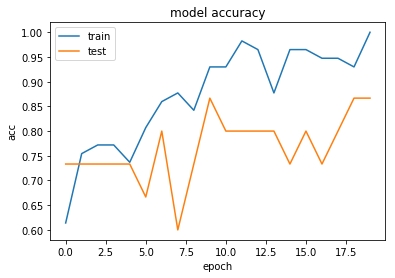

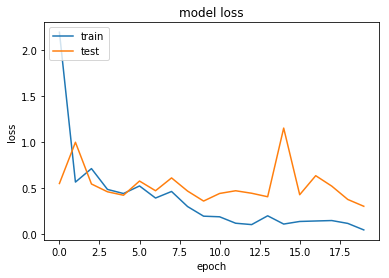

In [30]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
model.predict(x_test0)

array([[2.3213765e-02, 9.7678626e-01],
       [6.7541562e-04, 9.9932456e-01],
       [5.0824456e-02, 9.4917548e-01],
       [9.3438047e-01, 6.5619580e-02],
       [3.4833290e-02, 9.6516669e-01],
       [5.6746573e-04, 9.9943250e-01],
       [4.5956902e-05, 9.9995399e-01],
       [2.7327335e-03, 9.9726725e-01],
       [7.3975021e-01, 2.6024979e-01],
       [9.4779944e-01, 5.2200522e-02],
       [4.6243957e-01, 5.3756046e-01],
       [1.6747914e-02, 9.8325205e-01],
       [9.7132301e-01, 2.8677007e-02],
       [2.2088178e-01, 7.7911818e-01],
       [2.3402794e-01, 7.6597208e-01]], dtype=float32)

In [80]:
y_pred = model.predict_classes(x_test0)
y_pred = list(y_pred)
y_pred

[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]

In [53]:
y_test0

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [81]:
y_test1= np.argmax(y_test0, axis=1)
y_test1 =list(y_test1)
y_test1

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1]

In [84]:
print('Confusion Matrix')
print(confusion_matrix(y_test1, y_pred))
print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(y_test1, y_pred))#, target_names=target_names))

Confusion Matrix
[[ 3  1]
 [ 1 10]]
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.91      0.91      0.91        11

    accuracy                           0.87        15
   macro avg       0.83      0.83      0.83        15
weighted avg       0.87      0.87      0.87        15

